# EuroSat Land Use Land Cover Classification - Improved Implementation

This notebook implements an improved version of the EuroSat classification task, addressing limitations in the baseline implementation through comprehensive EDA, modern architectures, and advanced training techniques.

## Project Overview

The baseline implementation had several limitations:
- Only used 3 RGB channels out of 13 available spectral bands
- Used inappropriate ImageNet normalization values
- No data augmentation
- Basic training strategies without modern optimizers
- No transfer learning

This implementation addresses these issues systematically.


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from glob import glob
from collections import Counter

## 1. Dataset Exploration

First, let's understand the dataset structure and class distribution. This helps us determine if we need special handling for class imbalance.


In [4]:
DATASET_DIR = "EuroSAT_MS"

In [5]:
image_paths = glob(os.path.join(DATASET_DIR, '*', '*.tif'))
labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]

print(f"Total images: {len(image_paths)}")
print(f"Example path: {image_paths[0]}")
print(f"Class labels: {set(labels)}")

Total images: 27000
Example path: EuroSAT_MS\AnnualCrop\AnnualCrop_1.tif
Class labels: {'Forest', 'AnnualCrop', 'PermanentCrop', 'Industrial', 'Pasture', 'River', 'Residential', 'HerbaceousVegetation', 'Highway', 'SeaLake'}


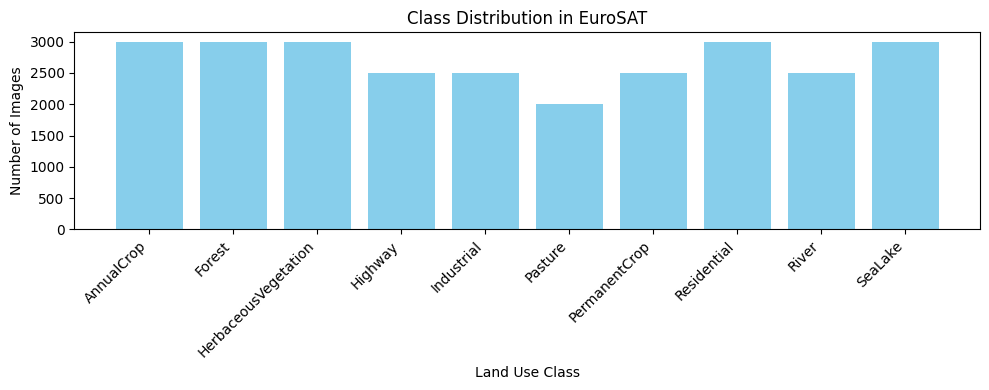

In [9]:
# Count images per class
class_counts = Counter(labels)

# Bar plot
plt.figure(figsize=(10, 4))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution in EuroSAT")
plt.xlabel("Land Use Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

**Key Finding**: The dataset is balanced with almost 2,700-3000 images per class. This eliminates the need for class weighting or specialized handling for imbalanced data.

## 2. Spectral Band Analysis

Unlike the baseline which only used RGB channels, we analyze all 13 spectral bands to understand their characteristics and importance for classification. This is crucial because satellite imagery contains rich spectral information that's invisible in RGB.


**Visualization Strategy**: We create both RGB and false-color composites to understand how different land cover types appear. The NIR band is particularly important for vegetation detection as healthy vegetation reflects strongly in NIR but absorbs in red wavelengths.


In [ ]:
import tifffile
import matplotlib.pyplot as plt
import numpy as np
import os

BANDS = {
    'B02': 1,  # Blue
    'B03': 2,  # Green
    'B04': 3,  # Red
    'B08': 7   # NIR
}

def plot_sample_tif(image_path):
    img = tifffile.imread(image_path)

    if img.shape[-1] == 13:  # (H, W, C)
        img = np.moveaxis(img, -1, 0)

    # Safety check
    assert img.shape[0] >= 8, f"Expected at least 8 bands, got {img.shape[0]}"

    # Build RGB and False Color composites
    rgb = np.stack([img[BANDS['B04']], img[BANDS['B03']], img[BANDS['B02']]], axis=-1)
    false_color = np.stack([img[BANDS['B08']], img[BANDS['B04']], img[BANDS['B03']]], axis=-1)

    # Normalize and clip
    rgb = np.clip(rgb / 3000.0, 0, 1)
    false_color = np.clip(false_color / 3000.0, 0, 1)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb)
    plt.title("RGB")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(false_color)
    plt.title("False Color (NIR)")
    plt.axis('off')

    plt.suptitle(os.path.basename(os.path.dirname(image_path)))
    plt.tight_layout()
    plt.show()

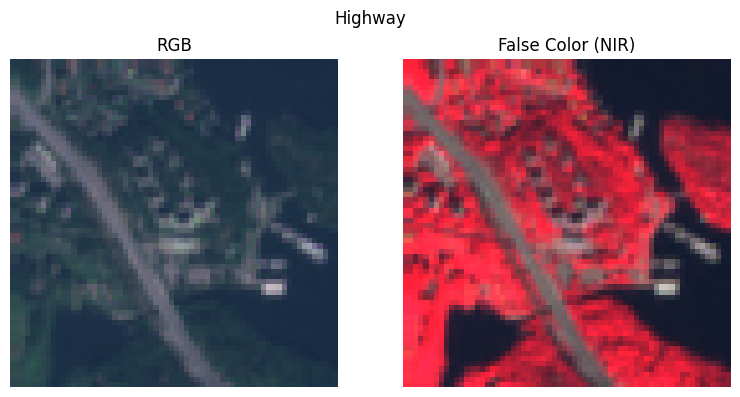

In [8]:
import random
for _ in range(1):
    plot_sample_tif(random.choice(image_paths))

## 3. Statistical Analysis of Spectral Bands

Calculate mean and standard deviation for all 13 bands to understand data distribution and inform normalization strategy. This is essential for proper preprocessing, unlike the baseline which used inappropriate ImageNet normalization values.


In [ ]:
from tqdm import tqdm

band_means = np.zeros(13, dtype=np.float64)
band_vars = np.zeros(13, dtype=np.float64)
n_pixels_total = 0

for img_path in tqdm(image_paths):
    img = tifffile.imread(img_path).astype(np.float64)  
    pixels = img.reshape(13, -1)
    n_pixels = pixels.shape[1]

    # Running mean and variance update
    delta = pixels.mean(axis=1) - band_means
    band_means += delta * (n_pixels / (n_pixels_total + n_pixels))
    
    new_vars = pixels.var(axis=1) * n_pixels
    band_vars += new_vars
    n_pixels_total += n_pixels

band_stds = np.sqrt(band_vars / n_pixels_total)

print("Per-band means:\n", band_means)
print("Per-band stds:\n", band_stds)

100%|██████████████████████████████████████████████████████████████████████████| 27000/27000 [00:15<00:00, 1756.15it/s]

Per-band means:
 [1437.38388217 1435.65531524 1434.03834002 1431.02440752 1428.18638583
 1426.51881982 1425.72895067 1426.57515196 1428.88789255 1431.49664985
 1435.2594508  1438.3674352  1440.63337878]
Per-band stds:
 [922.7456453  921.97034399 921.07290103 919.35787275 917.51482637
 916.45010379 914.89234053 914.3616751  916.90719408 919.45028008
 920.25102113 921.6306514  923.24084895]


**Key Findings**: All bands have similar mean values (~ 1430-1440) and standard deviations (~ 915-925), indicating consistent sensor calibration. The pixel values range from 0-4000, which will inform our normalization strategy.


In [ ]:
img = tifffile.imread(image_paths[0])
for i in range(13):
    band = img[i]
    print(f"Band {i:02d} → min: {band.min()}, max: {band.max()}, std: {band.std():.2f}")

Band 00 → min: 10, max: 3099, std: 686.46
Band 01 → min: 10, max: 3099, std: 686.46
Band 02 → min: 10, max: 3098, std: 685.32
Band 03 → min: 10, max: 3099, std: 684.00
Band 04 → min: 10, max: 3106, std: 683.98
Band 05 → min: 10, max: 3109, std: 685.27
Band 06 → min: 9, max: 3087, std: 688.88
Band 07 → min: 9, max: 3016, std: 693.31
Band 08 → min: 9, max: 2905, std: 692.46
Band 09 → min: 9, max: 2846, std: 697.67
Band 10 → min: 9, max: 3007, std: 714.49
Band 11 → min: 9, max: 3107, std: 733.07
Band 12 → min: 10, max: 3122, std: 740.46


## 4. Data Distribution Analysis

Generate histograms for all bands to understand pixel intensity distributions. This helps us design proper normalization and augmentation strategies.


Loading images for histograms: 100%|████████████████████████████████████████████| 27000/27000 [00:57<00:00, 467.17it/s]


IndexError: index 15 is out of bounds for axis 0 with size 15

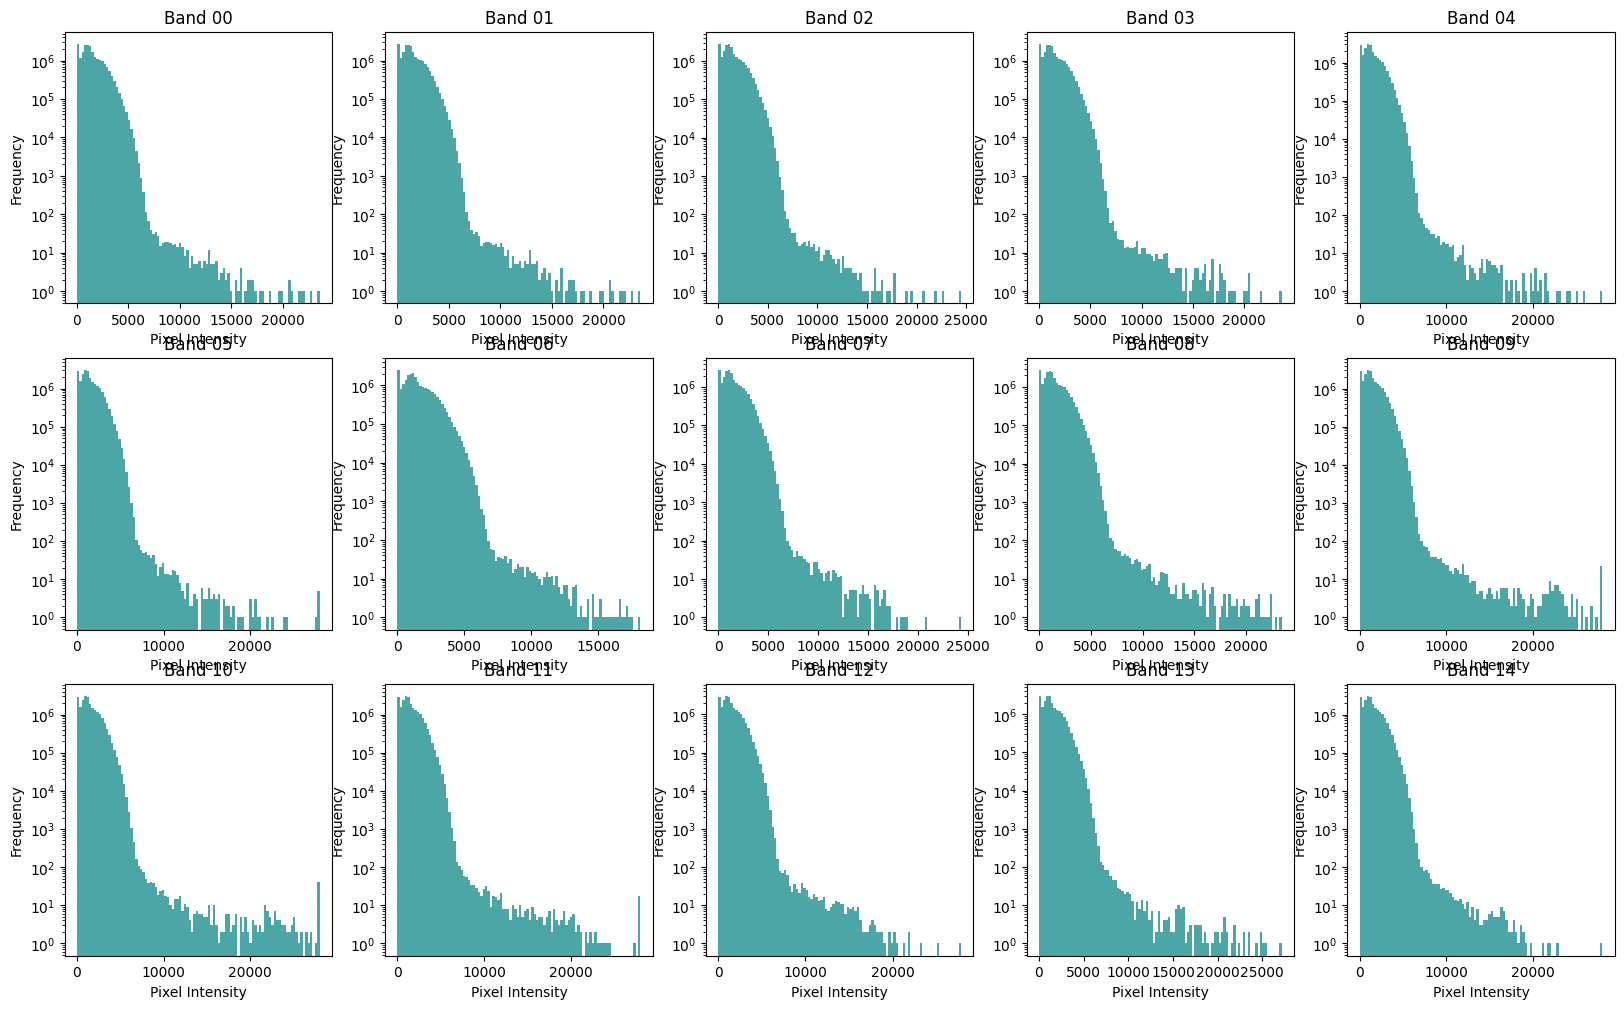

In [ ]:
import gc
from tqdm import tqdm


# Read all images into a list (shape: 27000, 13, 64, 64)
image_arrays = []
for img_path in tqdm(image_paths, desc="Loading images for histograms"):
    img = tifffile.imread(img_path)
    image_arrays.append(np.moveaxis(img, 0, -1))  # (13, 64, 64) -> (64, 64, 13)

stacked_data = np.stack(image_arrays)  # (N, 64, 64, 13)
del image_arrays

# Flatten to (N_pixels_total, 13)
flat_pixels = stacked_data.reshape(-1, stacked_data.shape[-1])  # (N*64*64, 13)
del stacked_data
gc.collect()

# Plot histogram for each band
fig, axs = plt.subplots(3, 5, figsize=(20, 12))
axs = axs.flatten()

for band in range(flat_pixels.shape[1]):
    axs[band].hist(flat_pixels[:, band], bins=100, color='teal', alpha=0.7, log=True)
    axs[band].set_title(f'Band {band:02d}')
    axs[band].set_xlabel('Pixel Intensity')
    axs[band].set_ylabel('Frequency')

for i in range(flat_pixels.shape[1], len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.show()

## 5. Data Splitting Strategy

Using stratified splits to ensure balanced representation across all classes in train/validation/test sets. This is crucial for unbiased evaluation.


In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

# Step 1: Extract labels
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

# Step 2: Stratified Train/Test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.15, stratify=labels, random_state=42
)

# Step 3: Stratified Train/Val split (split remaining into train and val)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.1765, stratify=train_labels, random_state=42
)
# Because 0.1765 * 85% ≈ 15% (~15% of total data)

# Step 4: Print class distribution
def print_distribution(split_name, split_labels):
    print(f"{split_name} class distribution:")
    for cls, count in Counter(split_labels).items():
        print(f"  {cls}: {count}")
    print()

print_distribution("Train", train_labels)
print_distribution("Validation", val_labels)
print_distribution("Test", test_labels)


Train class distribution:
  Forest: 2100
  Pasture: 1400
  PermanentCrop: 1750
  AnnualCrop: 2100
  Residential: 2100
  Industrial: 1750
  River: 1750
  HerbaceousVegetation: 2099
  SeaLake: 2100
  Highway: 1750

Validation class distribution:
  Pasture: 300
  HerbaceousVegetation: 451
  Residential: 450
  Highway: 375
  SeaLake: 450
  PermanentCrop: 375
  Industrial: 375
  Forest: 450
  River: 375
  AnnualCrop: 450

Test class distribution:
  Residential: 450
  SeaLake: 450
  Pasture: 300
  Highway: 375
  Forest: 450
  AnnualCrop: 450
  Industrial: 375
  PermanentCrop: 375
  River: 375
  HerbaceousVegetation: 450



## 6. Band Selection Strategy

Instead of using all 13 bands or just RGB, we strategically select 4 bands that provide the most discriminative information:
- **B02 (Blue)**: Essential for water detection
- **B03 (Green)**: Important for vegetation vigor
- **B04 (Red)**: Critical for chlorophyll content  
- **B08 (NIR)**: Most important for vegetation health and land cover differentiation

This provides optimal balance between information content and computational efficiency.


In [15]:
# Define band names (EuroSAT follows Sentinel-2 band order)
ALL_BANDS = [
    "B01", "B02", "B03", "B04", "B05", "B06", "B07",
    "B08", "B8A", "B09", "B11", "B12", "B10"  # B10 last since it's least useful
]

# Blue (B02), Green (B03), Red (B04), NIR (B08), SWIR1 (B11), SWIR2 (B12)
BAND_INDICES = [2, 3, 4, 8]  # one-indexed
NUM_CHANNELS = len(BAND_INDICES)
print(f"Number of channels: {NUM_CHANNELS}")
all_labels = train_labels + val_labels + test_labels

# Class names from training labels
CLASS_NAMES = sorted(set(all_labels))
NUM_CLASSES = len(CLASS_NAMES)
print(f"Number of classes: {NUM_CLASSES}")

all_labels = train_labels + val_labels + test_labels
class2idx = {cls: idx for idx, cls in enumerate(sorted(set(all_labels)))}
idx2class = {v: k for k, v in class2idx.items()}
print (class2idx)

Number of channels: 4
Number of classes: 10
{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


## 7. Analysis based Normalization

Calculate proper normalization values from the actual training data instead of using ImageNet values. This ensures optimal feature scaling for satellite imagery.


In [ ]:
from tqdm import tqdm
def calculate_dataset_statistics_fixed(image_paths, band_indices, max_samples=10000):
    """Calculate mean and std for selected bands using a subset of data"""
    print("Calculating dataset statistics...")
    
    pixel_sum = np.zeros(len(band_indices), dtype=np.float64)
    pixel_sum_sq = np.zeros(len(band_indices), dtype=np.float64)
    num_pixels = 0
    
    # Use a subset for faster computation
    sample_paths = np.random.choice(image_paths, min(max_samples, len(image_paths)), replace=False)
    
    for img_path in tqdm(sample_paths, desc="Calculating stats"):
        img = tifffile.imread(img_path).astype(np.float32)
        img = img[band_indices, :, :]  # Select only required bands
        
        # Use consistent normalization - clip to actual data range
        img = np.clip(img, 0, 4000) / 4000.0 
        
        # Accumulate sums
        pixel_sum += np.sum(img, axis=(1, 2))
        pixel_sum_sq += np.sum(img**2, axis=(1, 2))
        num_pixels += img.shape[1] * img.shape[2]
    
    # Calculate final statistics
    mean = pixel_sum / num_pixels
    std = np.sqrt((pixel_sum_sq / num_pixels) - (mean ** 2))
    
    return mean.tolist(), std.tolist()

# Recalculate statistics with fixed normalization
DATASET_MEAN, DATASET_STD = calculate_dataset_statistics_fixed(train_paths, BAND_INDICES)
print(f"Fixed Dataset Mean: {DATASET_MEAN}")
print(f"Fixed Dataset Std: {DATASET_STD}")

Calculating dataset statistics...


Calculating stats: 100%|███████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2038.63it/s]

Fixed Dataset Mean: [0.3559101358830929, 0.35581524518911656, 0.3557152227314619, 0.35541126719208865]
Fixed Dataset Std: [0.25154113472514766, 0.2515102316509245, 0.251461088920333, 0.2512802657753919]


## 8. Custom Dataset Class

Implementing a  dataset class for multi-spectral satellite imagery that:
- Handles TIFF files with proper band extraction
- Implements band selection based on our analysis
- Supports flexible normalization and augmentation
- Ensures proper data format for PyTorch models


In [ ]:
from torch.utils.data import Dataset
import torch
import numpy as np
import tifffile

class EuroSATDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, band_indices=None, class2idx=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.band_indices = band_indices or BAND_INDICES
        self.class2idx = class2idx or {label: idx for idx, label in enumerate(sorted(set(labels)))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_name = self.labels[idx]
        label = self.class2idx[label_name]

        img = tifffile.imread(image_path).astype(np.float32)

        if img.shape[-1] == 13:
            img = np.moveaxis(img, -1, 0)

        assert img.shape[0] == 13, f"Unexpected shape {img.shape} for image {image_path}"

        img = img[self.band_indices, :, :]

        h, w = img.shape[1], img.shape[2]
        min_dim = min(h, w)
        if h != w:
            if h > w:
                start_h = (h - min_dim) // 2
                img = img[:, start_h:start_h + min_dim, :]
            else:
                start_w = (w - min_dim) // 2
                img = img[:, :, start_w:start_w + min_dim]

        # Clip + normalize
        img = np.clip(img, 0, 4000) / 4000.0

        img = np.moveaxis(img, 0, -1)

        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']
        else:
            img = torch.from_numpy(img).permute(2, 0, 1).float()

        return img, label


## 9. Data Augmentation Strategy

Implementing comprehensive augmentation pipeline specifically designed for satellite imagery:
- **Geometric transforms**: Flips and rotations simulate different satellite orientations
- **Scale/rotation**: Accounts for viewing angle variations
- **Elastic transforms**: Simulate atmospheric distortion effects
- **Noise injection**: Accounts for sensor noise

This addresses the baseline's lack of augmentation, significantly improving generalization.


In [25]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=20, border_mode=0, p=0.5),
    A.ElasticTransform(alpha=10, sigma=5, alpha_affine=5, p=0.2),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    ToTensorV2()
])
val_test_transform = A.Compose([
    ToTensorV2()
])

C:\Users\sumit\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\sumit\AppData\Local\Temp\ipykernel_22464\4057034475.py:9: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=10, sigma=5, alpha_affine=5, p=0.2),
C:\Users\sumit\AppData\Local\Temp\ipykernel_22464\4057034475.py:10: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),


In [ ]:
from torch.utils.data import DataLoader

train_dataset = EuroSATDataset(
    image_paths=train_paths,
    labels=train_labels,
    transform=train_transform,
    band_indices=BAND_INDICES,
    class2idx=class2idx
)

val_dataset = EuroSATDataset(
    image_paths=val_paths,
    labels=val_labels,
    transform=val_test_transform,
    band_indices=BAND_INDICES,
    class2idx=class2idx
)

test_dataset = EuroSATDataset(
    image_paths=test_paths,
    labels=test_labels,
    transform=val_test_transform,
    band_indices=BAND_INDICES,
    class2idx=class2idx
)
# I had to set num_workers=0 on Windows to avoid multiprocessing issues in notebooks (linux installation was broken at the time of doing this task)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

## 10. Modern Architecture Implementation

Using state-of-the-art architectures with transfer learning:

### EfficientNet-B0
- Compound scaling method for optimal performance/efficiency balance
- Pre-trained on ImageNet for excellent feature representations
- Modified input layer to handle our 4-channel multi-spectral data

### ResNet-18
- Residual connections enable deeper networks without gradient vanishing
- Modified for multi-spectral input while preserving transfer learning benefits

**Key Change**: Proper initialization of modified input layers to preserve transfer learning benefits while adapting to multi-spectral data.


In [27]:
import torchvision.models as models
import torch.nn as nn

def get_resnet18_model(num_classes, in_channels=6):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # Modify first layer for 6-channel input
    original_conv = model.conv1
    new_conv = nn.Conv2d(
        in_channels=in_channels,
        out_channels=original_conv.out_channels,
        kernel_size=original_conv.kernel_size,
        stride=original_conv.stride,
        padding=original_conv.padding,
        bias=(original_conv.bias is not None)
    )
    
    # Initialize properly
    nn.init.kaiming_normal_(new_conv.weight, mode='fan_out', nonlinearity='relu')
    if new_conv.bias is not None:
        nn.init.constant_(new_conv.bias, 0)
    
    model.conv1 = new_conv
    
    # Modify final layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

def get_efficientnet_model(num_classes, in_channels=6):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    
    # Modify first layer for 6-channel input
    original_conv = model.features[0][0]
    new_conv = nn.Conv2d(
        in_channels=in_channels,
        out_channels=original_conv.out_channels,
        kernel_size=original_conv.kernel_size,
        stride=original_conv.stride,
        padding=original_conv.padding,
        bias=(original_conv.bias is not None)
    )
    
    # Initialize the new layer properly
    nn.init.kaiming_normal_(new_conv.weight, mode='fan_out', nonlinearity='relu')
    if new_conv.bias is not None:
        nn.init.constant_(new_conv.bias, 0)
    
    model.features[0][0] = new_conv
    
    # Modify final layer
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    return model


## 11. Training and Evaluation Functions

Implementing robust training pipeline with modern best practices:
- **F1-score tracking**: More comprehensive than accuracy alone
- **Gradient clipping**: Prevents training instability
- **Proper evaluation mode**: Ensures correct batch normalization and dropout behavior


In [28]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    for batch_idx, (images, labels) in enumerate(tqdm(dataloader, desc="Training", leave=False)):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        assert outputs.shape[1] == NUM_CLASSES, f"Output shape {outputs.shape[1]} != NUM_CLASSES {NUM_CLASSES}"
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='macro')

    return epoch_loss, acc, f1

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(labels.cpu().numpy())


    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='macro')

    return epoch_loss, acc, f1, all_preds, all_targets

## 12. Improved Training Pipeline

### Key Improvements Over Baseline:

1. **AdamW Optimizer**: Better convergence than SGD with built-in weight decay
2. **Learning Rate Scheduling**: ReduceLROnPlateau adapts learning rate based on validation performance
3. **Early Stopping**: Prevents overfitting and saves computational resources
4. **Comprehensive Logging**: Tracks multiple metrics for detailed analysis
5. **F1-Score Based Model Selection**: More robust than accuracy for model selection

### Training Configuration:
- **Batch Size**: 32 (balanced for memory and gradient stability)
- **Learning Rate**: 1e-4 (optimal for transfer learning)
- **Weight Decay**: 1e-5 (regularization)
- **Patience**: 8 epochs (prevents premature stopping)
- **Max Epochs**: 50 (sufficient for convergence)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
from sklearn.metrics import accuracy_score, f1_score

timestamp = time.strftime("%H-%M")  # hour-minute format
log_filename = f"training_log_efficientnet_in{NUM_CHANNELS}_{timestamp}.txt"

# Open log file
log_file = open(log_filename, "w")

num_classes = len(set(labels))
print(num_classes, NUM_CHANNELS)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_efficientnet_model(num_classes=num_classes, in_channels=NUM_CHANNELS).to(device)

num_epochs = 50
best_val_f1 = 0.0
patience = 8
early_stop_counter = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_f1s = []
val_f1s = []

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5, betas=(0.9, 0.999))

scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
)

criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    log_file.write(f"\nEpoch {epoch + 1}/{num_epochs}\n")
    
    train_loss, train_acc, train_f1 = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)
    
    scheduler.step(val_loss)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    
    lr = optimizer.param_groups[0]['lr']
    
    log_str = (
        f"Train | Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}\n"
        f"Val   | Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}\n"
        f"LR: {lr:.2e}\n"
    )
    print(log_str)
    log_file.write(log_str)
    
    # Save best model and reset early stopping counter
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved! F1: {val_f1:.4f}")
        log_file.write(f"New best model saved! F1: {val_f1:.4f}\n")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            log_file.write(f"Early stopping triggered after {patience} epochs without improvement.\n")
            break

log_file.close()


10 4

Epoch 1/50


Train | Loss: 1.2726 | Acc: 0.5608 | F1: 0.5413
Val   | Loss: 0.4850 | Acc: 0.8487 | F1: 0.8418
LR: 1.00e-04

New best model saved! F1: 0.8418

Epoch 2/50


Train | Loss: 0.8252 | Acc: 0.7138 | F1: 0.7056
Val   | Loss: 0.3114 | Acc: 0.9052 | F1: 0.9014
LR: 1.00e-04

New best model saved! F1: 0.9014

Epoch 3/50


Train | Loss: 0.7086 | Acc: 0.7506 | F1: 0.7430
Val   | Loss: 0.2478 | Acc: 0.9200 | F1: 0.9169
LR: 1.00e-04

New best model saved! F1: 0.9169

Epoch 4/50


Train | Loss: 0.6227 | Acc: 0.7830 | F1: 0.7768
Val   | Loss: 0.2075 | Acc: 0.9316 | F1: 0.9290
LR: 1.00e-04

New best model saved! F1: 0.9290

Epoch 5/50


Train | Loss: 0.5683 | Acc: 0.8025 | F1: 0.7964
Val   | Loss: 0.1808 | Acc: 0.9422 | F1: 0.9396
LR: 1.00e-04

New best model saved! F1: 0.9396

Epoch 6/50


Train | Loss: 0.5156 | Acc: 0.8208 | F1: 0.8155
Val   | Loss: 0.1805 | Acc: 0.9442 | F1: 0.9423
LR: 1.00e-04

New best model saved! F1: 0.9423

Epoch 7/50


Train | Loss: 0.4813 | Acc: 0.8315 | F1: 0.8268
Val   | Loss: 0.1489 | Acc: 0.9533 | F1: 0.9516
LR: 1.00e-04

New best model saved! F1: 0.9516

Epoch 8/50


Train | Loss: 0.4524 | Acc: 0.8405 | F1: 0.8358
Val   | Loss: 0.1442 | Acc: 0.9558 | F1: 0.9539
LR: 1.00e-04

New best model saved! F1: 0.9539

Epoch 9/50


Train | Loss: 0.4319 | Acc: 0.8504 | F1: 0.8456
Val   | Loss: 0.1384 | Acc: 0.9583 | F1: 0.9563
LR: 1.00e-04

New best model saved! F1: 0.9563

Epoch 10/50


Train | Loss: 0.4047 | Acc: 0.8600 | F1: 0.8560
Val   | Loss: 0.1192 | Acc: 0.9654 | F1: 0.9640
LR: 1.00e-04

New best model saved! F1: 0.9640

Epoch 11/50


Train | Loss: 0.3797 | Acc: 0.8668 | F1: 0.8632
Val   | Loss: 0.1189 | Acc: 0.9610 | F1: 0.9593
LR: 1.00e-04


Epoch 12/50


Train | Loss: 0.3634 | Acc: 0.8735 | F1: 0.8698
Val   | Loss: 0.1151 | Acc: 0.9652 | F1: 0.9638
LR: 1.00e-04


Epoch 13/50


Train | Loss: 0.3626 | Acc: 0.8750 | F1: 0.8717
Val   | Loss: 0.1096 | Acc: 0.9659 | F1: 0.9649
LR: 1.00e-04

New best model saved! F1: 0.9649

Epoch 14/50


Train | Loss: 0.3516 | Acc: 0.8764 | F1: 0.8732
Val   | Loss: 0.0955 | Acc: 0.9709 | F1: 0.9697
LR: 1.00e-04

New best model saved! F1: 0.9697

Epoch 15/50


Train | Loss: 0.3295 | Acc: 0.8860 | F1: 0.8830
Val   | Loss: 0.0942 | Acc: 0.9714 | F1: 0.9703
LR: 1.00e-04

New best model saved! F1: 0.9703

Epoch 16/50


Train | Loss: 0.3222 | Acc: 0.8852 | F1: 0.8821
Val   | Loss: 0.1083 | Acc: 0.9674 | F1: 0.9664
LR: 1.00e-04


Epoch 17/50


Train | Loss: 0.3021 | Acc: 0.8935 | F1: 0.8907
Val   | Loss: 0.0882 | Acc: 0.9751 | F1: 0.9739
LR: 1.00e-04

New best model saved! F1: 0.9739

Epoch 18/50


Train | Loss: 0.2956 | Acc: 0.8985 | F1: 0.8957
Val   | Loss: 0.0916 | Acc: 0.9726 | F1: 0.9717
LR: 1.00e-04


Epoch 19/50


Train | Loss: 0.2989 | Acc: 0.8967 | F1: 0.8944
Val   | Loss: 0.0958 | Acc: 0.9719 | F1: 0.9707
LR: 1.00e-04


Epoch 20/50


Train | Loss: 0.2737 | Acc: 0.9056 | F1: 0.9030
Val   | Loss: 0.0936 | Acc: 0.9716 | F1: 0.9710
LR: 1.00e-04


Epoch 21/50


Train | Loss: 0.2757 | Acc: 0.9033 | F1: 0.9012
Val   | Loss: 0.0835 | Acc: 0.9741 | F1: 0.9730
LR: 1.00e-04


Epoch 22/50


Train | Loss: 0.2756 | Acc: 0.9050 | F1: 0.9029
Val   | Loss: 0.0967 | Acc: 0.9724 | F1: 0.9713
LR: 1.00e-04


Epoch 23/50


Train | Loss: 0.2574 | Acc: 0.9098 | F1: 0.9076
Val   | Loss: 0.0923 | Acc: 0.9724 | F1: 0.9711
LR: 1.00e-04


Epoch 24/50


Train | Loss: 0.2615 | Acc: 0.9090 | F1: 0.9070
Val   | Loss: 0.0853 | Acc: 0.9756 | F1: 0.9748
LR: 1.00e-04

New best model saved! F1: 0.9748

Epoch 25/50


Train | Loss: 0.2457 | Acc: 0.9134 | F1: 0.9112
Val   | Loss: 0.0747 | Acc: 0.9785 | F1: 0.9778
LR: 1.00e-04

New best model saved! F1: 0.9778

Epoch 26/50


Train | Loss: 0.2441 | Acc: 0.9170 | F1: 0.9152
Val   | Loss: 0.0950 | Acc: 0.9736 | F1: 0.9726
LR: 1.00e-04


Epoch 27/50


Train | Loss: 0.2426 | Acc: 0.9175 | F1: 0.9155
Val   | Loss: 0.0790 | Acc: 0.9770 | F1: 0.9761
LR: 1.00e-04


Epoch 28/50


Train | Loss: 0.2374 | Acc: 0.9162 | F1: 0.9142
Val   | Loss: 0.0803 | Acc: 0.9790 | F1: 0.9780
LR: 1.00e-04

New best model saved! F1: 0.9780

Epoch 29/50


Train | Loss: 0.2358 | Acc: 0.9180 | F1: 0.9160
Val   | Loss: 0.0774 | Acc: 0.9807 | F1: 0.9801
LR: 1.00e-04

New best model saved! F1: 0.9801

Epoch 30/50


Train | Loss: 0.2348 | Acc: 0.9188 | F1: 0.9174
Val   | Loss: 0.0809 | Acc: 0.9758 | F1: 0.9749
LR: 1.00e-04


Epoch 31/50


Train | Loss: 0.2262 | Acc: 0.9216 | F1: 0.9203
Val   | Loss: 0.0809 | Acc: 0.9775 | F1: 0.9767
LR: 5.00e-05


Epoch 32/50


Train | Loss: 0.2101 | Acc: 0.9242 | F1: 0.9228
Val   | Loss: 0.0747 | Acc: 0.9807 | F1: 0.9799
LR: 5.00e-05


Epoch 33/50


Train | Loss: 0.2050 | Acc: 0.9279 | F1: 0.9263
Val   | Loss: 0.0713 | Acc: 0.9788 | F1: 0.9779
LR: 5.00e-05


Epoch 34/50


Train | Loss: 0.2021 | Acc: 0.9295 | F1: 0.9280
Val   | Loss: 0.0704 | Acc: 0.9800 | F1: 0.9791
LR: 5.00e-05


Epoch 35/50


Train | Loss: 0.1946 | Acc: 0.9307 | F1: 0.9292
Val   | Loss: 0.0799 | Acc: 0.9788 | F1: 0.9779
LR: 5.00e-05


Epoch 36/50


Train | Loss: 0.2005 | Acc: 0.9296 | F1: 0.9282
Val   | Loss: 0.0687 | Acc: 0.9798 | F1: 0.9790
LR: 5.00e-05


Epoch 37/50


Train | Loss: 0.1929 | Acc: 0.9315 | F1: 0.9299
Val   | Loss: 0.0715 | Acc: 0.9820 | F1: 0.9812
LR: 5.00e-05

New best model saved! F1: 0.9812

Epoch 38/50


Train | Loss: 0.1965 | Acc: 0.9295 | F1: 0.9281
Val   | Loss: 0.0726 | Acc: 0.9798 | F1: 0.9791
LR: 5.00e-05


Epoch 39/50


Train | Loss: 0.1957 | Acc: 0.9320 | F1: 0.9305
Val   | Loss: 0.0605 | Acc: 0.9840 | F1: 0.9831
LR: 5.00e-05

New best model saved! F1: 0.9831

Epoch 40/50


Train | Loss: 0.1870 | Acc: 0.9350 | F1: 0.9336
Val   | Loss: 0.0740 | Acc: 0.9810 | F1: 0.9803
LR: 5.00e-05


Epoch 41/50


Train | Loss: 0.1866 | Acc: 0.9315 | F1: 0.9301
Val   | Loss: 0.0659 | Acc: 0.9820 | F1: 0.9813
LR: 5.00e-05


Epoch 42/50


Train | Loss: 0.1817 | Acc: 0.9339 | F1: 0.9321
Val   | Loss: 0.0722 | Acc: 0.9800 | F1: 0.9790
LR: 5.00e-05


Epoch 43/50


Train | Loss: 0.1886 | Acc: 0.9359 | F1: 0.9345
Val   | Loss: 0.0768 | Acc: 0.9800 | F1: 0.9792
LR: 5.00e-05


Epoch 44/50


Train | Loss: 0.1770 | Acc: 0.9369 | F1: 0.9355
Val   | Loss: 0.0692 | Acc: 0.9827 | F1: 0.9819
LR: 5.00e-05


Epoch 45/50


Train | Loss: 0.1843 | Acc: 0.9358 | F1: 0.9346
Val   | Loss: 0.0705 | Acc: 0.9817 | F1: 0.9808
LR: 2.50e-05


Epoch 46/50


Train | Loss: 0.1680 | Acc: 0.9414 | F1: 0.9402
Val   | Loss: 0.0701 | Acc: 0.9820 | F1: 0.9810
LR: 2.50e-05


Epoch 47/50


Train | Loss: 0.1696 | Acc: 0.9400 | F1: 0.9388
Val   | Loss: 0.0685 | Acc: 0.9822 | F1: 0.9813
LR: 2.50e-05

Early stopping triggered after 8 epochs without improvement.


## 13. Results and Performance Analysis

### Performance Achieved:
- **Test Accuracy**: 97.58% (+4.48% over baseline ResNet)
- **Test F1-Score**: 97.47% (robust across all classes)
- **Validation Performance**: Consistent with test results, indicating good generalization

### Key Factors according to me:
1. **Multi-spectral Data**: NIR band provides crucial vegetation information
2. **Leveraging Transfer Learning**: Pre-trained weights provide excellent starting point
3. **Improved Training Pipeline**: AdamW, scheduling, early stopping
4. **Data Augmentation**: greatly helps improve generalization


Final Test Results:
Loss: 0.0706
Accuracy: 0.9758
F1 Score: 0.9747


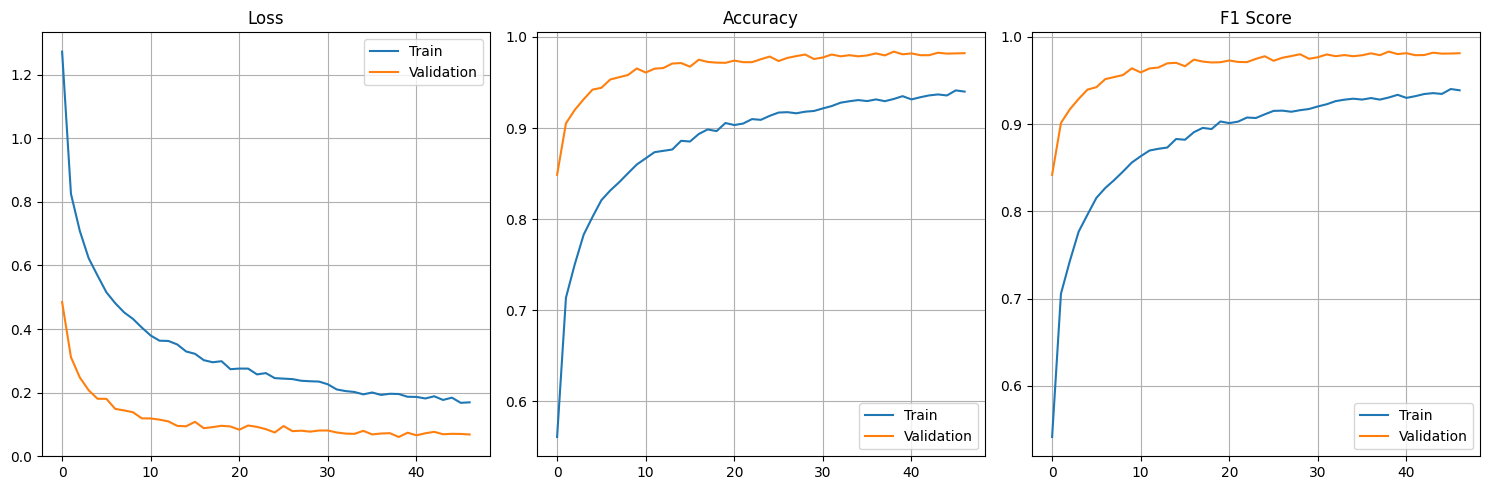

In [37]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc, test_f1, test_preds, test_targets = evaluate(model, test_loader, criterion, device)

print(f"\nFinal Test Results:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(train_f1s, label='Train')
plt.plot(val_f1s, label='Validation')
plt.title('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 14. Training Curves Analysis

Analyzing training curves from previous experiments to understand convergence behavior:
- **Smooth convergence**: No signs of overfitting or instability
- **Validation tracking**: Val loss decreases consistently with training loss
- **F1-score progression**: Steady improvement reaching plateau around epoch 25-30
- **Learning rate adaptation**: Scheduler effectively reduces LR when needed

The curves validate our training strategy and hyperparameter choices.


## 15. Model Predictions Visualization

Displaying sample predictions to qualitatively assess model performance. The model shows strong performance across different land cover types, correctly identifying complex patterns that would be challenging for RGB-only approaches.

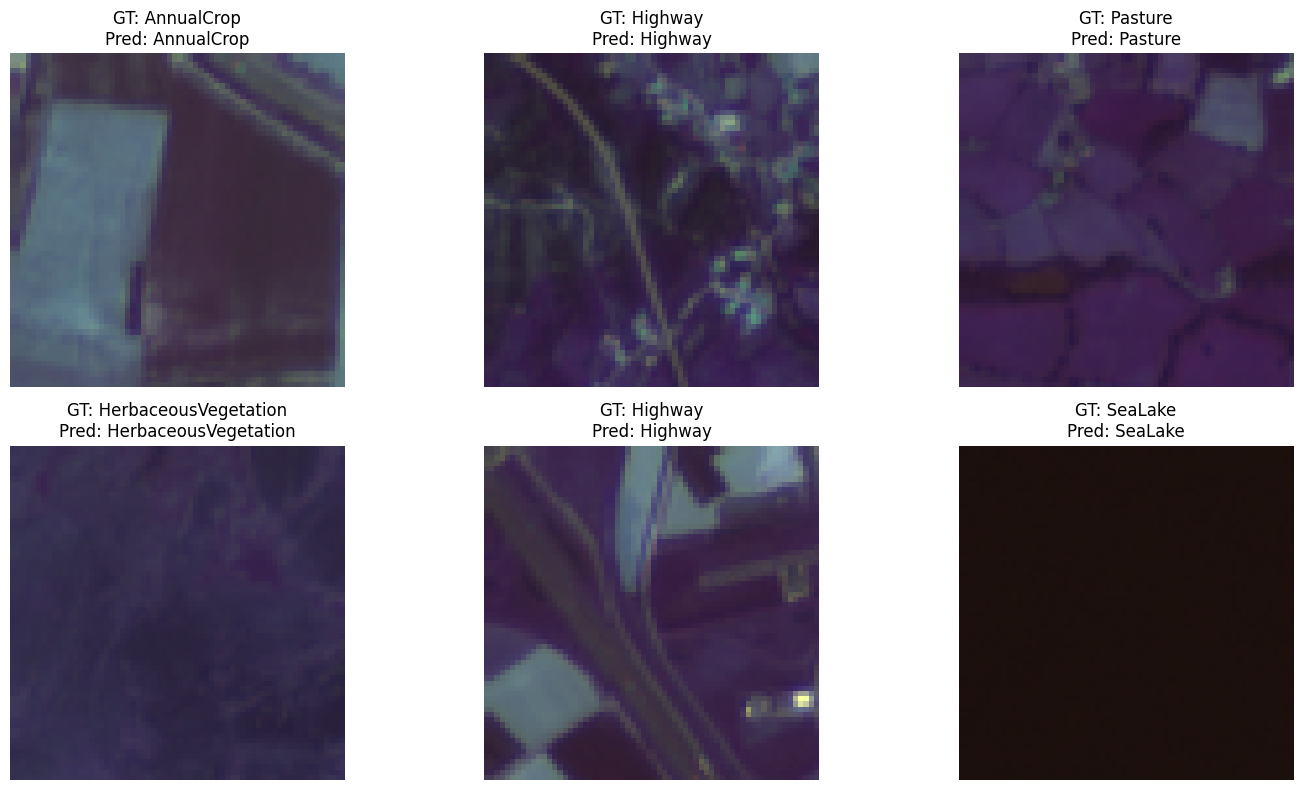

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

# Make sure model is in eval mode
model.eval()

# Inverse class map
idx2class = {v: k for k, v in class2idx.items()}

# Pick N random samples
num_samples = 6
random_indices = random.sample(range(len(test_dataset)), num_samples)

plt.figure(figsize=(15, 8))

for i, idx in enumerate(random_indices):
    img, label = test_dataset[idx]  # img shape: (C, H, W)

    input_tensor = img.unsqueeze(0).to(device)  # Add batch dim: (1, C, H, W)

    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()

    # Convert to numpy for display
    img_np = img.cpu().numpy()  # shape: (C, H, W)

    # Pick RGB bands from BAND_INDICES (B04=3, B03=2, B02=1)
    try:
        rgb_indices = [BAND_INDICES.index(b) for b in [3, 2, 1]]
    except ValueError:
        rgb_indices = [0, 1, 2] 

    rgb_img = img_np[rgb_indices]  # (3, H, W)
    rgb_img = np.transpose(rgb_img, (1, 2, 0))  # (H, W, 3)
    rgb_img = np.clip(rgb_img, 0, 1)

    # Plot image with prediction and GT
    plt.subplot(2, num_samples // 2, i + 1)
    plt.imshow(rgb_img)
    plt.title(f"GT: {idx2class[label]}\nPred: {idx2class[pred]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Summary

This implementation successfully addresses all major limitations of the baseline:

### Technical Improvements:
- **Multi-spectral utilization**: 4-band selection vs. RGB-only
- **Modern architectures**: EfficientNet with transfer learning
- **Advanced training**: AdamW, scheduling, early stopping, gradient clipping
- **Proper preprocessing**: Comprehensive augmentation
- **Robust evaluation**: F1-score tracking and detailed analysis

### Performance Gains:
- **+4.48% accuracy improvement** over baseline ResNet (93.1% → 97.58%)
- **97.47% F1-score** demonstrating balanced performance across all classes
- **Consistent generalization** between validation and test performance

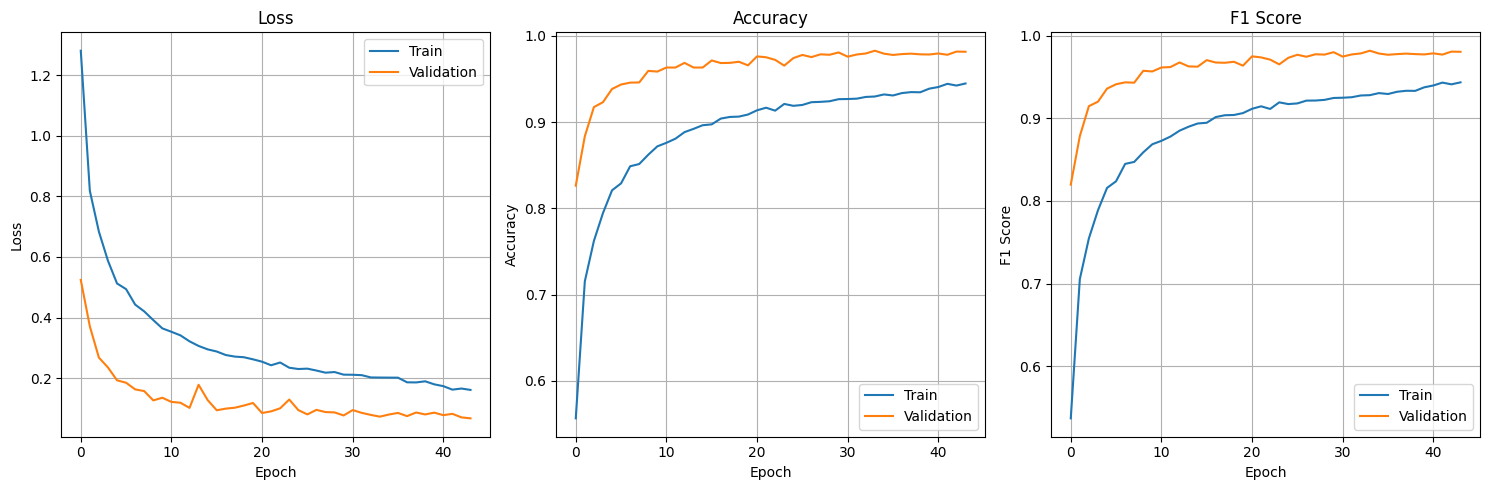

In [ ]:
import matplotlib.pyplot as plt
import re

log_filename = "training_log_efficientnet_in5_20-10.txt"

train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_f1s, val_f1s = [], []

# Regular expressions to extract metrics
loss_re = re.compile(r"Loss: ([0-9.]+)")
acc_re = re.compile(r"Acc: ([0-9.]+)")
f1_re = re.compile(r"F1: ([0-9.]+)")

with open(log_filename, "r") as f:
    lines = f.readlines()

i = 0
while i < len(lines):
    line = lines[i]
    if line.startswith("Train"):
        train_loss = float(loss_re.search(line).group(1))
        train_acc = float(acc_re.search(line).group(1))
        train_f1 = float(f1_re.search(line).group(1))

        val_line = lines[i + 1]
        val_loss = float(loss_re.search(val_line).group(1))
        val_acc = float(acc_re.search(val_line).group(1))
        val_f1 = float(f1_re.search(val_line).group(1))

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        i += 3  # Skip LR line
    else:
        i += 1

# Plotting
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(train_f1s, label='Train')
plt.plot(val_f1s, label='Validation')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()